In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Read and preprocess the data
df = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df.sort_values(by=["Date"], inplace=True, ascending=True)
df.to_csv("processed_sh.csv", index=False)

In [19]:
def generate_df_affect_by_n_days(series, n, index=False):
    if len(series) <= n:
        raise Exception("The Length of series is %d, while affect by (n=%d)." % (len(series), n))
    df = pd.DataFrame()
    for i in range(n):
        df['c%d' % i] = series.tolist()[i:-(n - i)]
    df['y'] = series.tolist()[n:]
    if index:
        df.index = series.index[n:]
    return df

def readData(column='Close', n=30, all_too=True, index=False, train_end=-300):
    df = pd.read_csv("processed_sh.csv")
    df.fillna(0, inplace=True)
    df.replace(to_replace="None", value=0)
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df.set_index('Date', inplace=True)
    df_column = df[column].copy()
    df_column_train, df_column_test = df_column[:train_end], df_column[train_end - n:]
    df_generate_from_df_column_train = generate_df_affect_by_n_days(df_column_train, n, index=index)
    print(df_generate_from_df_column_train)
    if all_too:
        return df_generate_from_df_column_train, df_column, df.index.tolist()
    return df_generate_from_df_column_train

class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=128, num_layers=2, batch_first=True, dropout=0.2)
        self.out = nn.Sequential(nn.Linear(128, 1))
        self.hidden = None
    
    def forward(self, x):
        r_out, self.hidden = self.rnn(x)
        out = self.out(r_out)
        return out

class TrainSet(Dataset):
    def __init__(self, data):
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

         c0      c1      c2      c3      c4      c5      c6      c7      c8  \
0    155.80  155.55  160.15  160.05  159.45  158.05  162.00  164.20  159.60   
1    155.55  160.15  160.05  159.45  158.05  162.00  164.20  159.60  161.85   
2    160.15  160.05  159.45  158.05  162.00  164.20  159.60  161.85  158.75   
3    160.05  159.45  158.05  162.00  164.20  159.60  161.85  158.75  165.45   
4    159.45  158.05  162.00  164.20  159.60  161.85  158.75  165.45  163.85   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
720  139.70  135.30  137.45  137.00  139.85  139.90  138.00  138.05  138.90   
721  135.30  137.45  137.00  139.85  139.90  138.00  138.05  138.90  142.40   
722  137.45  137.00  139.85  139.90  138.00  138.05  138.90  142.40  140.65   
723  137.00  139.85  139.90  138.00  138.05  138.90  142.40  140.65  144.55   
724  139.85  139.90  138.00  138.05  138.90  142.40  140.65  144.55  146.75   

         c9       y  
0    161.85  158.75  
1    15

151 tensor(0.0238, grad_fn=<MseLossBackward0>)
152 tensor(0.0363, grad_fn=<MseLossBackward0>)
153 tensor(0.0332, grad_fn=<MseLossBackward0>)
154 tensor(0.0199, grad_fn=<MseLossBackward0>)
155 tensor(0.0352, grad_fn=<MseLossBackward0>)
156 tensor(0.0462, grad_fn=<MseLossBackward0>)
157 tensor(0.0325, grad_fn=<MseLossBackward0>)
158 tensor(0.0299, grad_fn=<MseLossBackward0>)
159 tensor(0.0149, grad_fn=<MseLossBackward0>)
160 tensor(0.0138, grad_fn=<MseLossBackward0>)
161 tensor(0.0226, grad_fn=<MseLossBackward0>)
162 tensor(0.0250, grad_fn=<MseLossBackward0>)
163 tensor(0.0280, grad_fn=<MseLossBackward0>)
164 tensor(0.0219, grad_fn=<MseLossBackward0>)
165 tensor(0.0318, grad_fn=<MseLossBackward0>)
166 tensor(0.0822, grad_fn=<MseLossBackward0>)
167 tensor(0.0249, grad_fn=<MseLossBackward0>)
168 tensor(0.0180, grad_fn=<MseLossBackward0>)
169 tensor(0.0182, grad_fn=<MseLossBackward0>)
170 tensor(0.0601, grad_fn=<MseLossBackward0>)
171 tensor(0.0375, grad_fn=<MseLossBackward0>)
172 tensor(0.

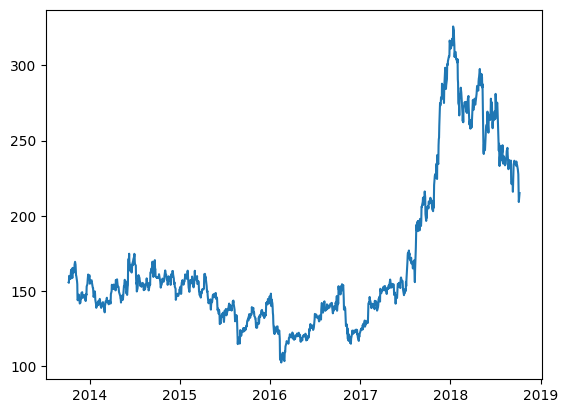

In [20]:
# Model training setup
n = 10
LR = 0.0001
EPOCH = 200
train_end = -500

# Prepare data
df, df_all, df_index = readData('Close', n=n, train_end=train_end)
df_all = np.array(df_all.tolist())
plt.plot(df_index, df_all, label='real-data')
df_numpy = np.array(df)
df_numpy_mean = np.mean(df_numpy)
df_numpy_std = np.std(df_numpy)
df_numpy = (df_numpy - df_numpy_mean) / df_numpy_std
df_tensor = torch.Tensor(df_numpy)
trainset = TrainSet(df_tensor)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Initialize model
rnn = RNN(n)
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.MSELoss()

# Training loop
for step in range(EPOCH):
    for tx, ty in trainloader:
        output = rnn(torch.unsqueeze(tx, dim=0))
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(step, loss)
    if step % 10 == 0:
        torch.save(rnn, 'rnn.pkl')

torch.save(rnn, 'rnn.pkl')

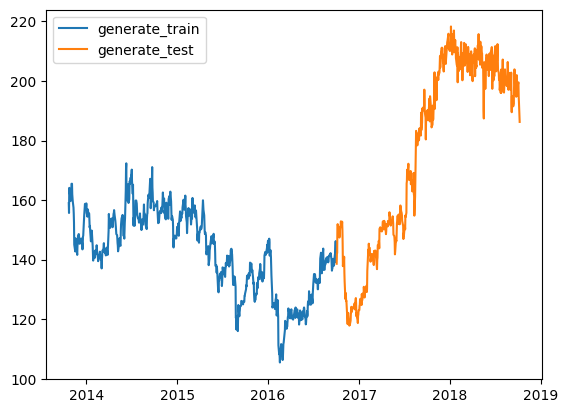

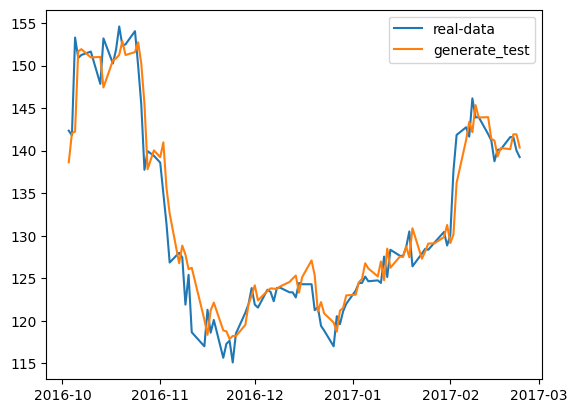

In [21]:
# Generate predictions for training and test data
generate_data_train = []
generate_data_test = []
test_index = len(df_all) + train_end
df_all_normal = (df_all - df_numpy_mean) / df_numpy_std
df_all_normal_tensor = torch.Tensor(df_all_normal)
for i in range(n, len(df_all)):
    x = df_all_normal_tensor[i - n:i]
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=0)
    y = rnn(x)
    if i < test_index:
        generate_data_train.append(torch.squeeze(y).detach().numpy() * df_numpy_std + df_numpy_mean)
    else:
        generate_data_test.append(torch.squeeze(y).detach().numpy() * df_numpy_std + df_numpy_mean)

plt.plot(df_index[n:train_end], generate_data_train, label='generate_train')
plt.plot(df_index[train_end:], generate_data_test, label='generate_test')
plt.legend()
plt.show()
plt.cla()
plt.plot(df_index[train_end:-400], df_all[train_end:-400], label='real-data')
plt.plot(df_index[train_end:-400], generate_data_test[:-400], label='generate_test')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure the actual data and predicted data have the same length
actual_data = df_all[train_end:]
predicted_data = generate_data_test[:len(actual_data)]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_data, predicted_data)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_data, predicted_data))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared
r_squared = r2_score(actual_data, predicted_data)
print(f"R-squared: {r_squared}")


Mean Absolute Error (MAE): 31.274189596411755
Root Mean Squared Error (RMSE): 44.64099050964076
R-squared: 0.4716945497857721
